

# Bitcoin’s Next Moves: A 1-Month Prediction with LSTM

##  Feature Summary of dataset

| Feature Name                     | Description                                                                 |
|----------------------------------|-----------------------------------------------------------------------------|
| `timestamp`                     |The date and time marking each hourly data entry (used as the index)        |
| `BTC_USDT_1h_open`              | The price at which Bitcoin started trading during the given hour (in USDT) |
| `BTC_USDT_1h_high`              | The maximum price reached by Bitcoin within that hour                      |
| `BTC_USDT_1h_low`               | minimum price recorded for Bitcoin in the same time frame                  |
| `BTC_USDT_1h_close`             | **Bitcoin’s final trading price for the hour** *(Target Variable)*         |
| `BTC_USDT_1h_volume`            | The total volume of Bitcoin traded (in USDT) during the hour               |
| `Google Trends: Bitcoin`        | Hourly search interest for the keyword “Bitcoin” from Google Trends        |
| `Google Trends: BTC`            | Google Trends data reflecting hourly interest in the term “BTC”            |
| `Crypto Fear & Greed Index`     | A sentiment indicator showing general market emotions toward crypto        |
| `Bitcoin Reddit Sentiment`      | A score measuring the sentiment of Reddit discussions about Bitcoin        |
| `Bitcoin News Sentiment`        | A sentiment score derived from Bitcoin-related news article                |
| `Bitcoin Market Dominance`      |Percentage share of Bitcoin’s market cap relative to  entire crypto market  |
| `RSI`                           | Relative Strength Index, used to identify overbought or oversold conditions|
| `Momentum`                      | Indicator reflecting price movement trends over recent hours               |
| `Volatility Index`              |	A measure of the market’s recent price fluctuation                         |

---

In [90]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Regression models
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Evaluation metrics
from sklearn.metrics import r2_score, mean_squared_error

# Deep learning layers and model structure
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential


# 1. Load dataset

In [91]:
df = pd.read_csv("/Users/daniel./Downloads/archive (3)/Bitcoin Pulse  Hourly Dataset from Markets Trends and Fear.csv")

# 2. Parse timestamp as datetime

In [92]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# 3.  quick look

In [93]:
df.shape

(17516, 98)

In [94]:
df.dtypes.head()

BNB_USDT_1h_open      float64
BNB_USDT_1h_high      float64
BNB_USDT_1h_low       float64
BNB_USDT_1h_close     float64
BNB_USDT_1h_volume    float64
dtype: object

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17516 entries, 2023-04-09 00:00:00 to 2025-04-07 19:00:00
Data columns (total 98 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   BNB_USDT_1h_open          17516 non-null  float64
 1   BNB_USDT_1h_high          17516 non-null  float64
 2   BNB_USDT_1h_low           17516 non-null  float64
 3   BNB_USDT_1h_close         17516 non-null  float64
 4   BNB_USDT_1h_volume        17516 non-null  float64
 5   BTC_USDT_1h_open          17516 non-null  float64
 6   BTC_USDT_1h_high          17516 non-null  float64
 7   BTC_USDT_1h_low           17516 non-null  float64
 8   BTC_USDT_1h_close         17516 non-null  float64
 9   BTC_USDT_1h_volume        17516 non-null  float64
 10  DOGE_USDT_1h_open         17516 non-null  float64
 11  DOGE_USDT_1h_high         17516 non-null  float64
 12  DOGE_USDT_1h_low          17516 non-null  float64
 13  DOGE_USDT_1h_close        

In [96]:
df.isnull().sum().sort_values(ascending=False).head(10)

BNB_USDT_1h_open        0
Open_dow_jones          0
High_dow_jones          0
Close_dow_jones         0
Volume_euro_stoxx_50    0
Open_euro_stoxx_50      0
Low_euro_stoxx_50       0
High_euro_stoxx_50      0
Close_euro_stoxx_50     0
Volume_cac_40           0
dtype: int64

# 4. Handle missing entries

In [97]:
df.fillna(method='ffill', inplace=True)

# 5. Plot BTC closing price

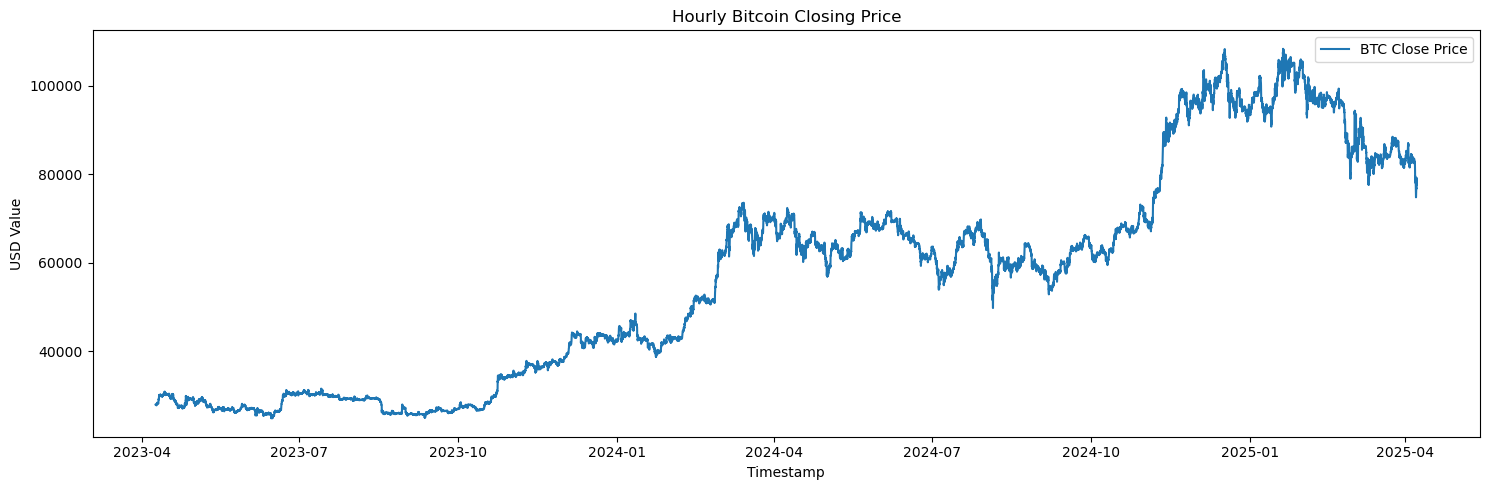

In [98]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df['BTC_USDT_1h_close'], label='BTC Close Price')
ax.set_title("Hourly Bitcoin Closing Price")
ax.set_xlabel("Timestamp")
ax.set_ylabel("USD Value")
ax.legend()
plt.tight_layout()
plt.show()


# 6. Correlation heatmap

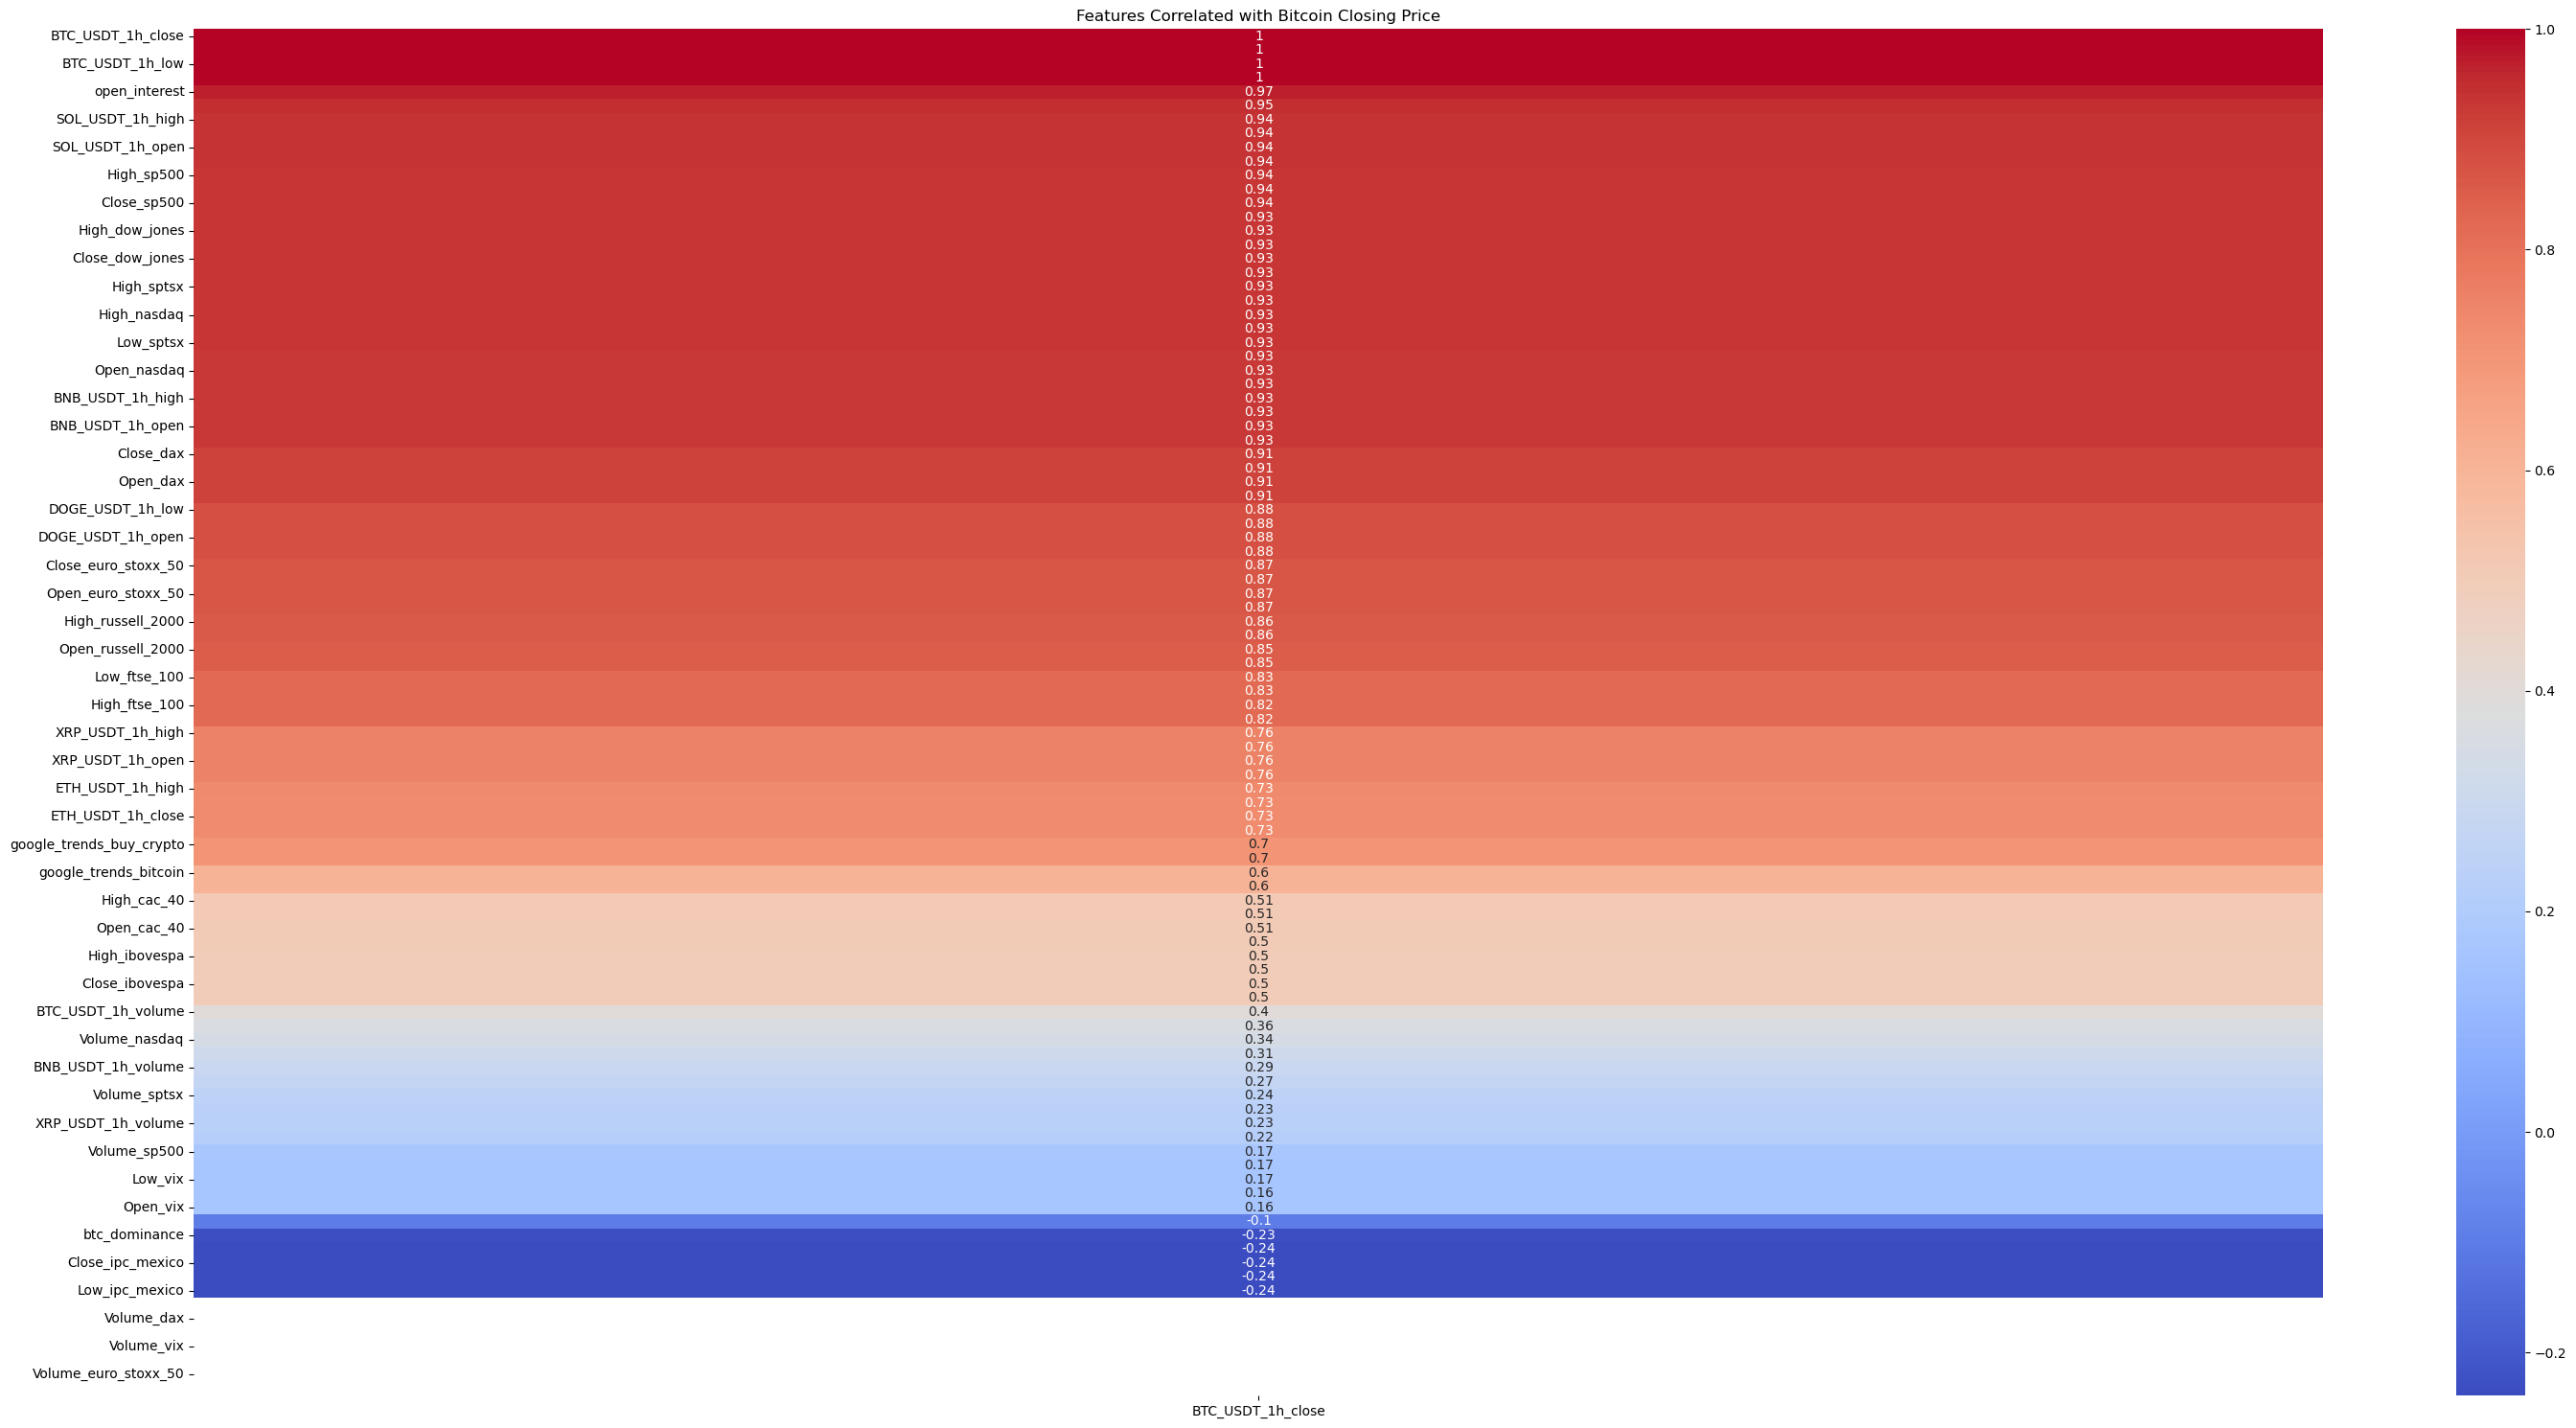

In [99]:
fig, ax = plt.subplots(figsize=(30, 15))
correlations = df.corr()
target_corr = correlations[['BTC_USDT_1h_close']].sort_values(by='BTC_USDT_1h_close', ascending=False)
sns.heatmap(target_corr, annot=True, cmap='coolwarm', ax=ax)
ax.set_title("Features Correlated with Bitcoin Closing Price")
plt.tight_layout()
plt.show()


# 7. Engineering features: % shift per hour

In [100]:
selected_cols = ['BTC_USDT_1h_close', 'BNB_USDT_1h_close', 'Open_sp500', 'fear_greed_index', 'btc_dominance']
pct_changes = df[selected_cols].pct_change()
pct_changes.columns = [f"{col}_pct_change" for col in pct_changes.columns]

df = pd.concat([df, pct_changes], axis=1)
df.dropna(inplace=True)

# 8. Feature selection

In [101]:
correlation = df.corr()['BTC_USDT_1h_close'].abs().sort_values(ascending=False)
top_corr_features = correlation[1:20].index.tolist()

In [102]:
X = df[top_corr_features]
y = df['BTC_USDT_1h_close']

# 9. Split  data

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 10. Define models

In [104]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=537)
}

# 11. Train and evaluate models

In [105]:
results = dict()

for model_name in regression_models:
    current_model = regression_models[model_name]
    current_model.fit(X_train, y_train)
    
    predicted_values = current_model.predict(X_test)
    mse_score = mean_squared_error(y_test, predicted_values)
    r2_val = r2_score(y_test, predicted_values)

    results[model_name] = {
        "MSE": mse_score,
        "R2": r2_val
    }

    print(f"\nPerformance of {model_name}:")
    print("MSE:", mse_score)
    print("R2 Score:", r2_val)




Performance of LinearRegression:
MSE: 37228.090798857906
R2 Score: 0.999234257028998

Performance of Ridge:
MSE: 37227.542547810284
R2 Score: 0.9992342683059499

Performance of Lasso:
MSE: 112630.65787176884
R2 Score: 0.997683304925557

Performance of RandomForest:
MSE: 94167433.01420344
R2 Score: -0.9369258100695688


# 12. Visualize predictions

In [106]:
best_model = Ridge(alpha=1.0)
best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)

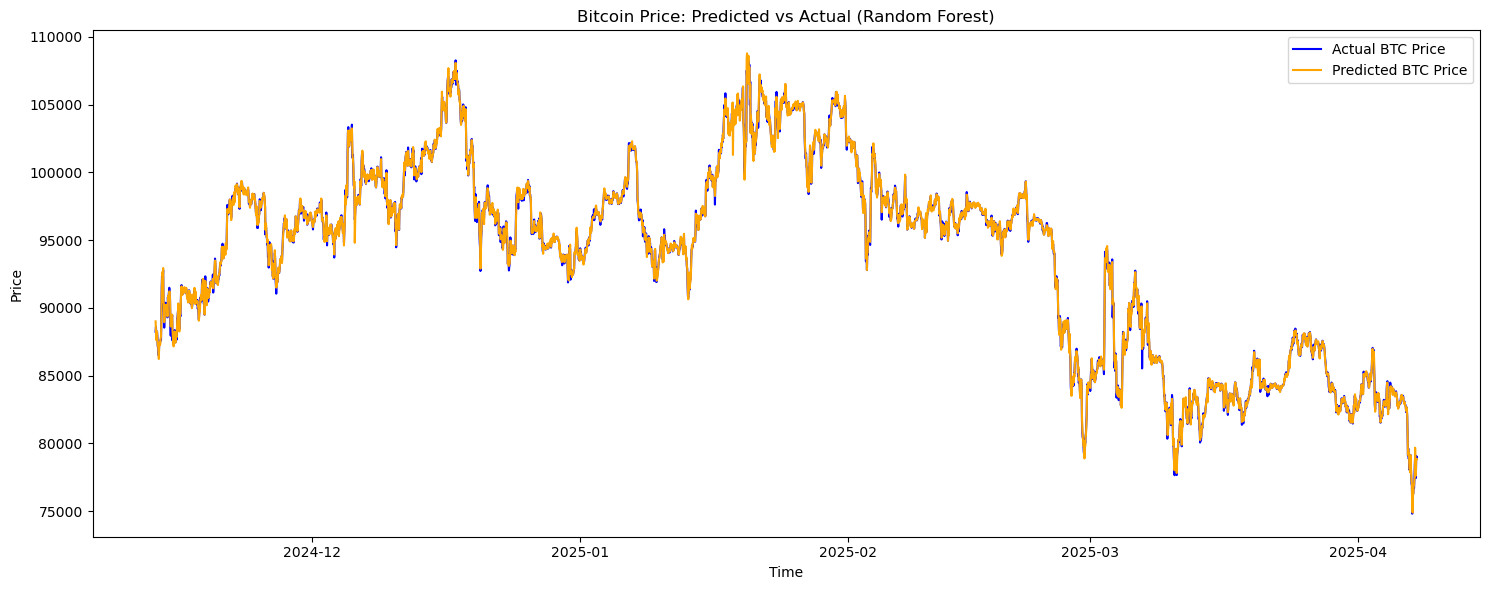

In [107]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)

ax.plot(y_test.index, y_test, color='blue', label='Actual BTC Price')
ax.plot(y_test.index, preds, color='orange', label='Predicted BTC Price')

ax.set_title("Bitcoin Price: Predicted vs Actual (Random Forest)")
ax.set_xlabel("Time")
ax.set_ylabel("Price")
ax.legend()

plt.tight_layout()
plt.show()

## 13.ONE-MONTH BITCOIN PRICE PREDICTION WITH LSTM

In [108]:
df = pd.read_csv("/Users/daniel./Downloads/archive (3)/Bitcoin Pulse  Hourly Dataset from Markets Trends and Fear.csv")

## 1. Use only the bitcoin prices that are closing

In [109]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df.fillna(method='ffill', inplace=True)

btc_prices = df[['BTC_USDT_1h_close']].copy()
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(btc_prices)

## 2. Create input sequences

In [110]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

SEQ_LENGTH = 72  
X, y = create_sequences(scaled_prices, SEQ_LENGTH)

In [111]:
X = X.reshape((X.shape[0], X.shape[1], 1))

## 3. Train and test split

In [112]:
split_idx = int(X.shape[0] * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

## 4. Build LSTM model

In [113]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(SEQ_LENGTH, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


## 5. Train  model

In [114]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 40s 86ms/step - loss: 0.0044 - val_loss: 5.1164e-04
Epoch 2/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - loss: 4.8937e-04 - val_loss: 3.6839e-04
Epoch 3/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 33s 75ms/step - loss: 4.4546e-04 - val_loss: 2.1645e-04
Epoch 4/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 33s 77ms/step - loss: 3.4528e-04 - val_loss: 0.0010
Epoch 5/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 2.9263e-04 - val_loss: 2.8320e-04
Epoch 6/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 36s 82ms/step - loss: 2.6327e-04 - val_loss: 7.9349e-04
Epoch 7/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 33s 75ms/step - loss: 2.8055e-04 - val_loss: 8.6045e-04
Epoch 8/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 33s 75ms/step - loss: 2.4085e-04 - val_loss: 1.7635e-04
Epoch 9/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - loss: 2.1370e-04 - val_loss: 2.3272e-04
Epoch 10/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - loss: 2.0186e-04 - val_loss: 1.2024e-04


Projection for the Upcoming 30 Days (Hourly Breakdown)

In [115]:
future_steps = 720
last_sequence = scaled_prices[-SEQ_LENGTH:].reshape(1, SEQ_LENGTH, 1)
future_predictions = []

for _ in range(future_steps):
    next_pred = model.predict(last_sequence, verbose=0)[0][0]  # 👈 Added verbose=0
    future_predictions.append(next_pred)
    new_seq = np.append(last_sequence[:, 1:, :], [[[next_pred]]], axis=1)
    last_sequence = new_seq

## 7. Inverse transform predictions

In [116]:
future_prices = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

## 8. Create future time index

In [117]:
future_index = pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), periods=future_steps, freq='H')


## 9. Plot

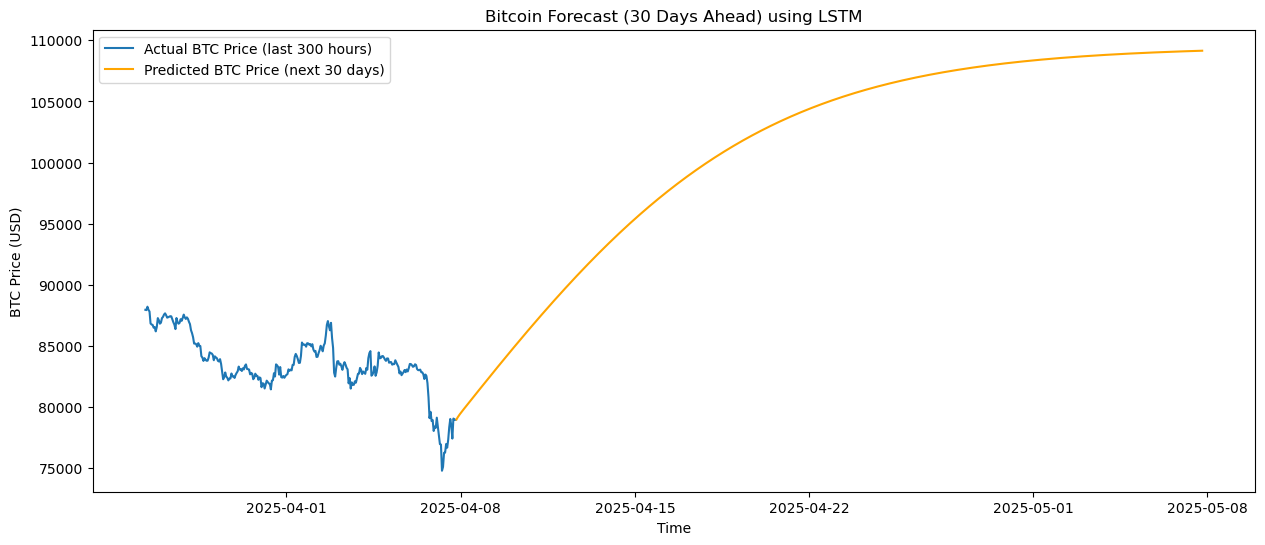

In [118]:
plt.figure(figsize=(15, 6))
plt.plot(df.index[-300:], btc_prices[-300:], label="Actual BTC Price (last 300 hours)")
plt.plot(future_index, future_prices, label="Predicted BTC Price (next 30 days)", color='orange')
plt.title("Bitcoin Forecast (30 Days Ahead) using LSTM")
plt.xlabel("Time")
plt.ylabel("BTC Price (USD)")
plt.legend()
plt.show()

##  Project Summary: Hourly Bitcoin Price Forecasting Using Regression and Deep Learning

###  Objective
The purpose of this project is to analyze hourly Bitcoin market data to:
- Perform comprehensive data analysis,
- Identify the most impactful features through feature selection techniques,
- Build regression models to establish baseline performance,
- Implement a deep learning model (LSTM) to **predict Bitcoin prices for the next 30 days** based on historical data.

##  Steps and Methodology

### 1. Data Preprocessing and Exploration
- Missing values were handled using forward-fill (`ffill`).
- The `timestamp` column was parsed into datetime format and set as the index.
- Numerical features were scaled using MinMax normalization to prepare for modeling.

### 2. Correlation Analysis & Feature Selection
- A correlation matrix was generated to identify features with the highest correlation (positive and negative) to the target variable.
- The main target selected was `BTC_USDT_1h_close` (hourly closing price).
- Feature selection was guided by correlation strength and `R²` score performance.

### 3. Regression Modeling and Comparison
- Several regression models were trained: Linear Regression, Ridge, Lasso and Random Forest.
- Their performances were evaluated and compared using the R² score on a hold-out test set.

### 4. LSTM-Based Time Series Forecasting
- A Long Short-Term Memory (LSTM) neural network was developed using 72-hour input windows.
- The model was trained to forecast **720 future time steps** (i.e., the next 30 days of hourly BTC prices).
- The prediction loop was configured to run silently (`verbose=0`) to avoid excessive console output.

### 5. Visualization
- The last 300 hours of actual BTC prices were plotted alongside the 30-day forecast.
- A clear time-based chart was produced to illustrate the model's predictive performance visually.
